In [8]:
import pysam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 0. Разобраться с minimap2

Запустим minimap2 для ридов PacBio и Oxford Nanopores

In [83]:
!conda run minimap2 -Y -c --MD -ax map-pb data/reference.fasta data/pacbio_40x.fq > data/pacbio-aln.sam
!conda run minimap2 -Y -c --MD -ax map-pb data/reference.fasta data/ONT_2D.fastq > data/ont-aln.sam

[M::mm_idx_gen::0.121*1.01] collected minimizers
[M::mm_idx_gen::0.137*1.23] sorted minimizers
[M::main::0.137*1.23] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.144*1.22] mid_occ = 11
[M::mm_idx_stat] kmer size: 19; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.150*1.21] distinct minimizers: 606828 (98.95% are singletons); average occurrences: 1.024; average spacing: 7.468
[M::worker_pipeline::38.006*2.82] mapped 41447 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -Y -c --MD -ax map-pb data/reference.fasta data/pacbio_40x.fq
[M::main] Real time: 38.049 sec; CPU: 107.144 sec; Peak RSS: 1.622 GB

[M::mm_idx_gen::0.182*0.99] collected minimizers
[M::mm_idx_gen::0.204*1.20] sorted minimizers
[M::main::0.204*1.20] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.213*1.20] mid_occ = 11
[M::mm_idx_stat] kmer size: 19; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.221*1.19] distinct minimizers: 606828 (98.95% are singleton

Определим процент приложившихся ридов

In [84]:
!samtools flagstat data/pacbio-aln.sam

[W::sam_read1] Parse error at line 52084
[bam_flagstat_core] Truncated file? Continue anyway.
52081 + 0 in total (QC-passed reads + QC-failed reads)
1736 + 0 secondary
8898 + 0 supplementary
0 + 0 duplicates
51199 + 0 mapped (98.31% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [85]:
!samtools flagstat data/ont-aln.sam

[W::sam_read1] Parse error at line 32096
[bam_flagstat_core] Truncated file? Continue anyway.
32093 + 0 in total (QC-passed reads + QC-failed reads)
1063 + 0 secondary
220 + 0 supplementary
0 + 0 duplicates
29297 + 0 mapped (91.29% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


98.31% для pacbio и 91.29% для Oxford Nanopores

In [86]:
!samtools view -b data/pacbio-aln.sam > data/pacbio-aln.bam
!samtools sort data/pacbio-aln.bam > data/pacbio-aln.sorted.bam
!samtools index data/pacbio-aln.sorted.bam

!samtools view -b data/ont-aln.sam > data/ont-aln.bam
!samtools sort data/ont-aln.bam > data/ont-aln.sorted.bam
!samtools index data/ont-aln.sorted.bam

[W::sam_read1] Parse error at line 52084
samtools view: error reading file "data/pacbio-aln.sam"
[W::sam_read1] Parse error at line 32096
samtools view: error reading file "data/ont-aln.sam"


# 1. Статистики ридов PacBio и Oxford Nanopores.

Покрытие генома

In [87]:
def coverage(al_path, avg=1000):
    bamfile = pysam.AlignmentFile(al_path, 'rb')
    ref_name = bamfile.get_reference_name(0)
    ref_len = bamfile.get_reference_length(ref_name)
    
    pos_cov = np.array([0] * ref_len)
    
    for line in bamfile:
        blocks = line.get_blocks()
        if len(blocks) > 0:
            for cov in blocks:
                pos_cov[cov[0]: cov[1]] += 1
    
    pos_cov_avg = []
    pos_cov_avg_lab = []
    
    for i in range(0, len(pos_cov), avg):
        pos_cov_avg_lab.append(f'({i}, {i + avg})')
        pos_cov_avg.append(pos_cov[i: i + avg].mean())
    
    cov_prop = len(pos_cov[pos_cov != 0]) / len(pos_cov)
    cov_mean = pos_cov.mean()
    
    print('Доля покрытой области:', cov_prop * 100, '%')
    print('Среднее покрытие:', cov_mean)
    
    plt.figure(figsize=(20, 15))
    plt.plot(pos_cov_avg_lab, pos_cov_avg)
    plt.xticks(rotation='vertical')
    plt.ylim([0, max(pos_cov_avg) + 20])
    plt.show()

Доля покрытой области: 100.0 %
Среднее покрытие: 38.98064778244166


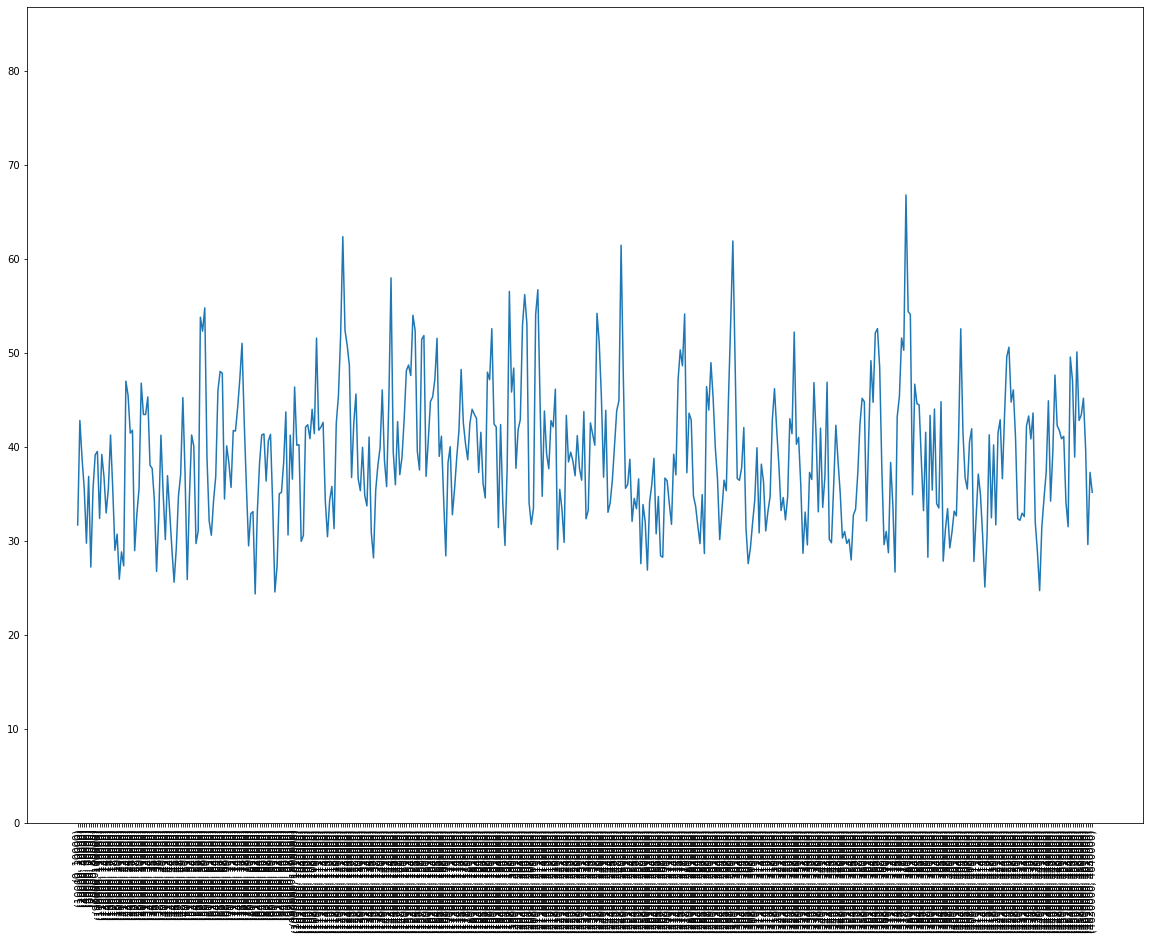

In [88]:
coverage(f'data/pacbio-aln.sorted.bam', avg=10000)

Доля покрытой области: 99.98118402689843 %
Среднее покрытие: 26.849222413207823


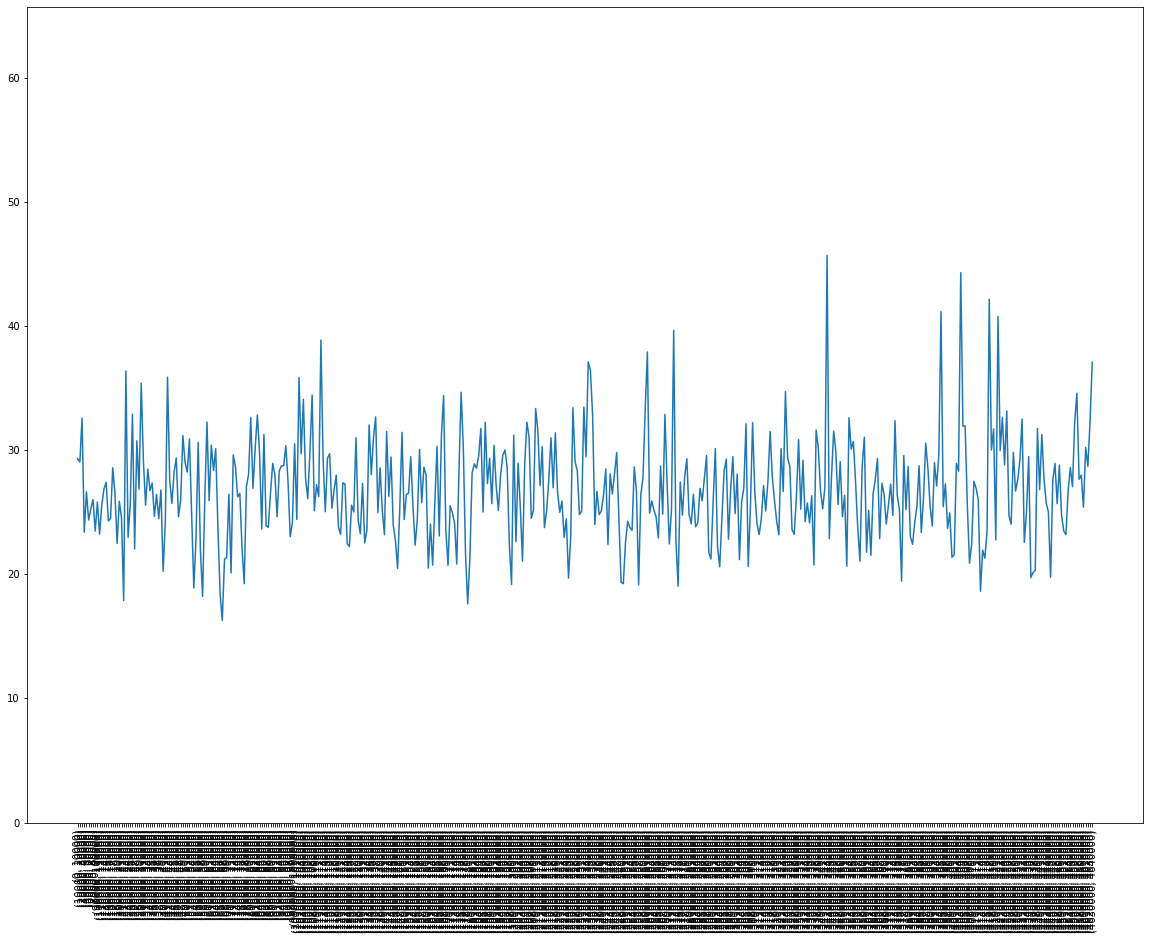

In [89]:
coverage(f'data/ont-aln.bam', avg=10000)

# Процент ошибок и частоты замен

In [101]:
def errors(al_path):
    bamfile = pysam.AlignmentFile(al_path, 'rb')
    ref_name = bamfile.get_reference_name(0)
    
    indel_length = []
    errors = []
    
    freq = {
        'A': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '_': 0},
        'C': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '_': 0},
        'G': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '_': 0},
        'T': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '_': 0},
        '_': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '_': 0}
    }
    
    ins_qual = []
    mismatch_qual = []
        
    for line in bamfile.fetch(ref_name):
        cigar = line.cigartuples
        read_len = line.query_length
        pairs = line.get_aligned_pairs(with_seq=True)
        
        qual = line.query_alignment_qualities
        
        ci = 0
        ciwd = 0
        err = 0
        
        for s in cigar: 
            
            if s[0] == 0: # match/mismatch
                for ip, p in enumerate(pairs[ci:ci + s[1]]):
                    if p[2] in ['a', 'c', 'g', 't']:
                        freq[line.query_sequence[p[0]]][p[2].upper()] += 1
                        err += 1
                        if len(qual) <= ciwd + ip:
                            print(ci, ip, ciwd)
                            print(len(qual))
                            print('pairs', len(pairs))
                            print(read_len)
                            print(cigar)
                        mismatch_qual.append(qual[ciwd + ip])
            elif s[0] == 1: # insertion
                indel_length.append(s[1])
                err += s[1]
                for ip, p in enumerate(pairs[ci:ci + s[1]]):
                    if p[0] is not None:
                        freq[line.query_sequence[p[0]]]['_'] += 1
                        if len(qual) <= ciwd + ip:
                            print(ci, ip, ciwd)
                            print(len(qual))
                            print('pairs', len(pairs))
                            print(read_len)
                            print(cigar)
                        ins_qual.append(qual[ciwd + ip])
                
            elif s[0] == 2: # del
                indel_length.append(s[1])
                err += s[1]
                for p in pairs[ci:ci + s[1]]:
                    if p[2] is not None:
                        freq['_'][p[2].upper()] += 1
            
            ci += s[1]
            if s[0] != 2 and s[0] != 4 and s[0] != 5:
                ciwd += s[1]
        
        errors.append(err / read_len)
        
    print(f'Средний процент ошибок в ридах: {np.mean(errors) * 100}%')
    print('----')
    print(f'Средняя длина индела: {np.mean(indel_length)}')
    print(f'Стандартное отклонение индела: {np.std(indel_length)}')
    print(f'Минимум индела: {np.min(indel_length)}')
    print(f'Максимум индела: {np.max(indel_length)}')
    print('----')
    print(f'Среднее качество нуклеотида при ошибочно вставленном нуклеотиде: {np.mean(ins_qual)}')
    print(f'Стандартное отклонение качества нуклеотида при ошибочно вставленном нуклеотиде: {np.std(ins_qual)}')
    print('----')
    print(f'Среднее качество нуклеотида при замене: {np.mean(mismatch_qual)}')
    print(f'Стандартное отклонение качества нуклеотида при замене: {np.std(mismatch_qual)}')
    print('----')
    print(pd.DataFrame(freq))
    print('----')
    print('Распределение длин инделов')
    plt.hist(np.array(indel_length))
    plt.show()

Средний процент ошибок в ридах: 10.391423667855433%
----
Средняя длина индела: 1.440768342589235
Стандартное отклонение индела: 3.284786397529793
Минимум индела: 1
Максимум индела: 2798
----
Среднее качество нуклеотида при ошибочно вставленном нуклеотиде: 6.785956109924352
Стандартное отклонение качества нуклеотида при ошибочно вставленном нуклеотиде: 4.416557597227938
----
Среднее качество нуклеотида при замене: 6.568421696914785
Стандартное отклонение качества нуклеотида при замене: 4.497145123747102
----
         A        C        G        T        _
A        0   362042   314646   293065  1468795
C   469562        0   424447   332423  2115301
G   332883   426388        0   462468  2110350
T   293076   316460   367469        0  1464530
_  4011908  4706056  4708271  4001714        0
----
Распределение длин инделов


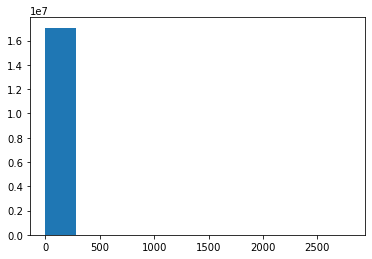

In [102]:
errors('data/pacbio-aln.sorted.bam')

Средний процент ошибок в ридах: 7.784994132831252%
----
Средняя длина индела: 1.8632717351319952
Стандартное отклонение индела: 3.695410976634774
Минимум индела: 1
Максимум индела: 1196
----
Среднее качество нуклеотида при ошибочно вставленном нуклеотиде: 11.127115485943639
Стандартное отклонение качества нуклеотида при ошибочно вставленном нуклеотиде: 7.210388957653209
----
Среднее качество нуклеотида при замене: 8.37727348766355
Стандартное отклонение качества нуклеотида при замене: 4.953979992471293
----
        A       C       G       T        _
A       0  110205  364960  102861  1610807
C  134745       0   83531  336777  1542768
G  316879   89685       0  124222  1567723
T  105194  369690  108899       0  1607078
_  392652  372619  389270  388426        0
----
Распределение длин инделов


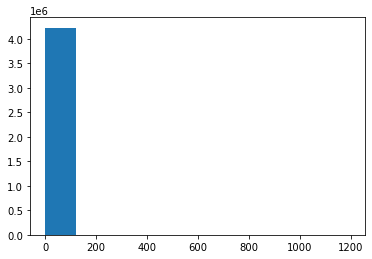

In [103]:
errors('data/ont-aln.sorted.bam')

У нанопоры меньшее среднее покрытие, но в то же время меньший процент ошибок